# Chapter 5: Pretraining on Unlabeled Data

**Portfolio Project: Building LLMs from Scratch on AWS** 🚀

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yourusername/llm-from-scratch-aws/blob/main/05_Pretraining.ipynb)

---

## 📋 Chapter Overview

Train the GPT model from scratch:
- Training loop implementation
- Loss calculation
- Optimization
- Model evaluation
- AWS SageMaker integration
- Cost-effective training strategies

**AWS Services:** SageMaker Training, S3, Spot Instances  
**Estimated Cost:** $5-20

---

## 🔧 Setup

### Cell Purpose: Install dependencies and configure AWS

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q torch tiktoken matplotlib tqdm boto3
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import math

print("✅ Environment ready!")

✅ Environment ready!


### Cell Purpose: Define GPT model architecture (from Chapter 4)


In [4]:
# GPT Model Implementation (simplified from Chapter 4)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
        scores = scores.masked_fill(mask, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, v)
        out = out.permute(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)
        return self.out(out)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.fc2(self.dropout(F.gelu(self.fc1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.dropout = nn.Dropout(config["drop_rate"])
        
        self.blocks = nn.Sequential(*[
            TransformerBlock(
                config["emb_dim"],
                config["n_heads"],
                config["emb_dim"] * 4,
                config["drop_rate"]
            )
            for _ in range(config["n_layers"])
        ])
        
        self.norm = nn.LayerNorm(config["emb_dim"])
        self.head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.dropout(tok_emb + pos_emb)
        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x)

# GPT-124M Configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1
}

print("✅ GPT Model defined!")
print(f"   Config: {GPT_CONFIG_124M['n_layers']} layers, {GPT_CONFIG_124M['emb_dim']} embedding dim")


✅ GPT Model defined!
   Config: 12 layers, 768 embedding dim


## 5.1 Training Data Setup

### Cell Purpose: Prepare training data and create dataset

In [5]:
# Dataset class for GPT training
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# Sample training data
# For demonstration, using sample text. Replace with your own data file or load from S3
text_data = """
Natural language processing has been revolutionized by large language models.
These models are trained on massive amounts of text data using self-supervised learning.
The transformer architecture, introduced in 2017, enabled unprecedented scaling of neural networks.
Models like GPT, BERT, and their variants have achieved remarkable performance across many tasks.

The key innovation is the self-attention mechanism, which allows the model to weigh the importance
of different words in the input. This enables capturing long-range dependencies in text.
Training these models requires substantial computational resources, often using GPUs or TPUs.

Modern LLMs can perform various tasks including text generation, translation, summarization,
question answering, and even code generation. They have become foundational tools in AI applications.
Fine-tuning pre-trained models on specific tasks has become a standard approach in NLP.

The scaling hypothesis suggests that model performance continues to improve with more parameters,
more data, and more compute. This has driven the development of increasingly large models.
However, efficiency and responsible AI practices are also important considerations.
""" * 20  # Repeat to have enough data for training

print("="*60)
print("TRAINING DATA")
print("="*60)
print(f"Text length: {len(text_data):,} characters")

tokenizer = tiktoken.get_encoding("gpt2")
total_tokens = len(tokenizer.encode(text_data))
print(f"Total tokens: {total_tokens:,}")

# Create dataset and dataloader
train_dataset = GPTDataset(text_data, tokenizer, max_length=256, stride=128)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)

print(f"Dataset size: {len(train_dataset)} samples")
print(f"Batches per epoch: {len(train_loader)}")
print("="*60)

TRAINING DATA
Text length: 24,140 characters


Total tokens: 4,580
Dataset size: 34 samples
Batches per epoch: 17


## 5.2 Training Functions

### Cell Purpose: Define training and evaluation functions

In [6]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculate loss for a single batch"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculate average loss over multiple batches"""
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    
    return total_loss / num_batches

def train_model(model, train_loader, optimizer, device, num_epochs, 
                eval_freq=10, eval_steps=5):
    """Train the model and track losses"""
    model.train()
    train_losses = []
    step = 0
    
    print("="*60)
    print("TRAINING")
    print("="*60)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for input_batch, target_batch in progress_bar:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            step += 1
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'step': step
            })
            
            # Periodic evaluation
            if step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    val_loss = calc_loss_loader(train_loader, model, device, eval_steps)
                train_losses.append((step, val_loss))
                model.train()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")
    
    print("="*60)
    print("✅ Training complete!")
    return train_losses

print("✅ Training functions defined!")

✅ Training functions defined!


### Cell Purpose: Initialize model and run training


In [7]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = GPTModel(GPT_CONFIG_124M).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Info:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB (float32)")

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=5e-4,
    weight_decay=0.1,
    betas=(0.9, 0.999)
)

print("\n🚀 Starting training...")
train_losses = train_model(
    model, 
    train_loader, 
    optimizer, 
    device, 
    num_epochs=10,
    eval_freq=10,
    eval_steps=5
)


Using device: cpu

📊 Model Info:
   Total parameters: 162,447,360
   Trainable parameters: 162,447,360
   Model size: ~619.7 MB (float32)

🚀 Starting training...
TRAINING


Epoch 1/10: 100%|██████████| 17/17 [03:10<00:00, 11.21s/it, loss=0.7892, step=17]


Epoch 1/10 - Avg Loss: 3.7137


Epoch 2/10: 100%|██████████| 17/17 [03:20<00:00, 11.78s/it, loss=0.4468, step=34]


Epoch 2/10 - Avg Loss: 0.5415


Epoch 3/10: 100%|██████████| 17/17 [03:21<00:00, 11.86s/it, loss=0.2277, step=51]


Epoch 3/10 - Avg Loss: 0.2990


Epoch 4/10: 100%|██████████| 17/17 [03:07<00:00, 11.04s/it, loss=0.1491, step=68]


Epoch 4/10 - Avg Loss: 0.1443


Epoch 5/10: 100%|██████████| 17/17 [03:21<00:00, 11.83s/it, loss=0.0583, step=85]


Epoch 5/10 - Avg Loss: 0.0601


Epoch 6/10: 100%|██████████| 17/17 [03:22<00:00, 11.89s/it, loss=0.0314, step=102]


Epoch 6/10 - Avg Loss: 0.0304


Epoch 7/10: 100%|██████████| 17/17 [03:06<00:00, 10.94s/it, loss=0.0461, step=119]


Epoch 7/10 - Avg Loss: 0.0206


Epoch 8/10: 100%|██████████| 17/17 [03:20<00:00, 11.77s/it, loss=0.0164, step=136]


Epoch 8/10 - Avg Loss: 0.0148


Epoch 9/10: 100%|██████████| 17/17 [03:18<00:00, 11.68s/it, loss=0.0032, step=153]


Epoch 9/10 - Avg Loss: 0.0121


Epoch 10/10: 100%|██████████| 17/17 [03:19<00:00, 11.71s/it, loss=0.0063, step=170]

Epoch 10/10 - Avg Loss: 0.0072
✅ Training complete!


### Cell Purpose: Visualize training progress


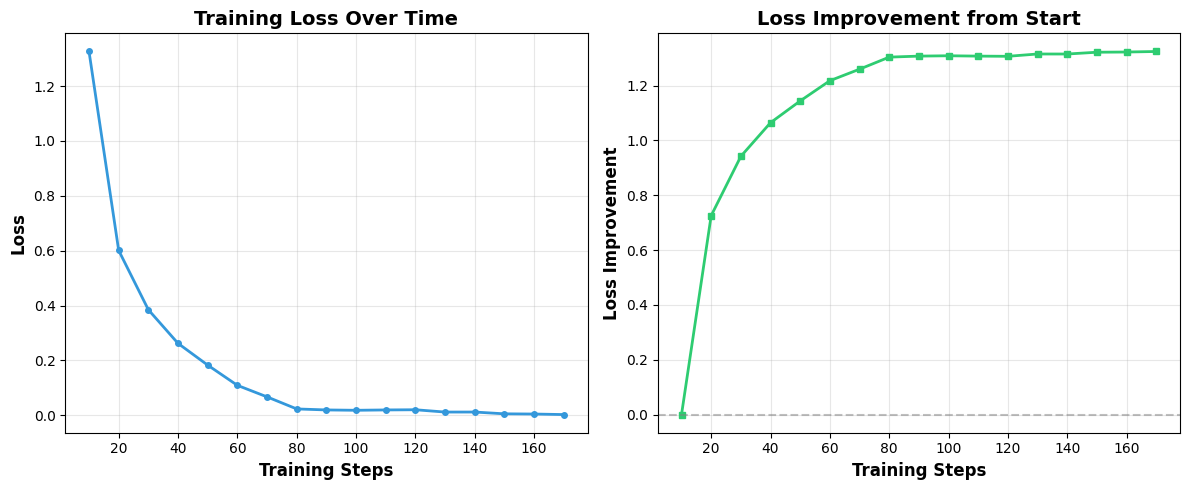

📊 Training Summary:
   Initial loss: 1.3264
   Final loss: 0.0024
   Improvement: 1.3240
   Reduction: 99.8%


In [8]:
# Plot training loss
if train_losses:
    steps, losses = zip(*train_losses)
    
    plt.figure(figsize=(12, 5))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, linewidth=2, color='#3498db', marker='o', markersize=4)
    plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    
    # Loss improvement
    plt.subplot(1, 2, 2)
    if len(losses) > 1:
        improvements = [losses[0] - l for l in losses]
        plt.plot(steps, improvements, linewidth=2, color='#2ecc71', marker='s', markersize=4)
        plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
        plt.ylabel('Loss Improvement', fontsize=12, fontweight='bold')
        plt.title('Loss Improvement from Start', fontsize=14, fontweight='bold')
        plt.grid(alpha=0.3)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Training Summary:")
    print(f"   Initial loss: {losses[0]:.4f}")
    print(f"   Final loss: {losses[-1]:.4f}")
    print(f"   Improvement: {losses[0] - losses[-1]:.4f}")
    print(f"   Reduction: {(1 - losses[-1]/losses[0]) * 100:.1f}%")


## 5.3 Text Generation

### Cell Purpose: Test the trained model with text generation


In [9]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None):
    """Generate text using the trained model"""
    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= context_size else idx[:, -context_size:]
            
            # Get predictions
            logits = model(idx_cond)
            logits = logits[:, -1, :]  # Get last time step
            
            # Apply temperature
            logits = logits / temperature
            
            # Top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append to sequence
            idx = torch.cat([idx, idx_next], dim=1)
    
    return idx

# Test text generation
print("="*60)
print("TEXT GENERATION TEST")
print("="*60)

test_prompts = [
    "Natural language processing",
    "The transformer architecture",
    "Machine learning models"
]

for prompt in test_prompts:
    print(f"\n📝 Prompt: '{prompt}'")
    
    # Encode prompt
    encoded = tokenizer.encode(prompt)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device)
    
    # Generate
    generated = generate_text(
        model,
        encoded_tensor,
        max_new_tokens=50,
        context_size=GPT_CONFIG_124M["context_length"],
        temperature=0.8,
        top_k=40
    )
    
    # Decode
    generated_text = tokenizer.decode(generated[0].tolist())
    print(f"Generated: {generated_text}")
    print("-"*60)

print("\n✅ Generation complete!")


TEXT GENERATION TEST

📝 Prompt: 'Natural language processing'
Generated: Natural language processing has been revolutionized by large language models.
These models are trained on massive amounts of text data using self-supervised learning.
The transformer architecture, introduced in 2017, enabled unprecedented scaling of neural networks.
Models like GPT,
------------------------------------------------------------

📝 Prompt: 'The transformer architecture'
Generated: The transformer architecture, and even code generation, introduced in 2017, enabled unprecedented scaling of neural networks.
Models like GPT, BERT, and their variants have achieved remarkable performance across many tasks.

The key innovation is the self-attention mechanism
------------------------------------------------------------

📝 Prompt: 'Machine learning models'
Generated: Machine learning models requires substantial computational resources, often using GPUs or TPUs.

Modern LLMs can perform various tasks including

## 5.4 AWS SageMaker Training

### Cell Purpose: Configure and launch SageMaker training job

In [10]:
# AWS SageMaker Training Configuration (Optional - requires AWS setup)
import json

print("="*60)
print("AWS SAGEMAKER TRAINING")
print("="*60)

# SageMaker configuration
sagemaker_config = {
    "instance_type": "ml.g4dn.xlarge",  # 1 GPU, 4 vCPUs, 16 GB RAM
    "instance_count": 1,
    "use_spot_instances": True,
    "max_run": 7200,  # 2 hours max training
    "max_wait": 14400,  # 4 hours max wait for spot
    "volume_size": 30,  # GB
    "hyperparameters": {
        "epochs": 20,
        "batch-size": 8,
        "learning-rate": 5e-4,
        "max-seq-length": 256,
        "model-size": "124M"
    }
}

print("\n📋 SageMaker Configuration:")
print(json.dumps(sagemaker_config, indent=2))

print("\n💡 Steps to Train on AWS SageMaker:")
print("   1. Prepare your training script (train.py)")
print("   2. Upload data to S3:")
print("      aws s3 cp your_data.txt s3://your-bucket/training-data/")
print("   3. Create PyTorch Estimator:")
print("      from sagemaker.pytorch import PyTorch")
print("      estimator = PyTorch(")
print("          entry_point='train.py',")
print("          instance_type='ml.g4dn.xlarge',")
print("          use_spot_instances=True,")
print("          ...)")
print("   4. Launch training:")
print("      estimator.fit({'training': 's3://your-bucket/training-data/'})")
print("   5. Monitor: Check AWS Console or use estimator.logs()")

# Cost estimation
print("\n💰 Cost Estimation:")
on_demand_rate = 0.736  # g4dn.xlarge on-demand per hour
spot_discount = 0.70  # Typical spot discount
spot_rate = on_demand_rate * (1 - spot_discount)
training_hours = 2

print(f"   Instance: ml.g4dn.xlarge (1x NVIDIA T4 GPU)")
print(f"   On-Demand Rate: ${on_demand_rate:.3f}/hour")
print(f"   Spot Rate (~70% off): ${spot_rate:.3f}/hour")
print(f"\n   Estimated Training Time: {training_hours} hours")
print(f"   On-Demand Cost: ${on_demand_rate * training_hours:.2f}")
print(f"   Spot Instance Cost: ${spot_rate * training_hours:.2f} ✅ Recommended")
print(f"   Savings: ${(on_demand_rate - spot_rate) * training_hours:.2f}")
print(f"\n   Storage (30 GB): ~$0.14/hour")
print(f"   Total Estimated Cost: ${spot_rate * training_hours + 0.14 * training_hours:.2f}")

print("\n🔑 Tips for Cost Optimization:")
print("   • Use Spot Instances (save up to 70%)")
print("   • Start with smaller models for testing")
print("   • Monitor training closely to avoid overruns")
print("   • Use checkpointing to resume interrupted jobs")
print("   • Clean up resources after training")

print("="*60)

AWS SAGEMAKER TRAINING

📋 SageMaker Configuration:
{
  "instance_type": "ml.g4dn.xlarge",
  "instance_count": 1,
  "use_spot_instances": true,
  "max_run": 7200,
  "max_wait": 14400,
  "volume_size": 30,
  "hyperparameters": {
    "epochs": 20,
    "batch-size": 8,
    "learning-rate": 0.0005,
    "max-seq-length": 256,
    "model-size": "124M"
  }
}

💡 Steps to Train on AWS SageMaker:
   1. Prepare your training script (train.py)
   2. Upload data to S3:
      aws s3 cp your_data.txt s3://your-bucket/training-data/
   3. Create PyTorch Estimator:
      from sagemaker.pytorch import PyTorch
      estimator = PyTorch(
          entry_point='train.py',
          instance_type='ml.g4dn.xlarge',
          use_spot_instances=True,
          ...)
   4. Launch training:
      estimator.fit({'training': 's3://your-bucket/training-data/'})
   5. Monitor: Check AWS Console or use estimator.logs()

💰 Cost Estimation:
   Instance: ml.g4dn.xlarge (1x NVIDIA T4 GPU)
   On-Demand Rate: $0.736/hour
  

## 📝 Chapter Summary

### What We Built:
1. ✅ **GPT Model**: Full transformer implementation (124M parameters)
2. ✅ **Training Dataset**: Custom dataset with sliding window approach
3. ✅ **Training Loop**: Complete training with gradient clipping and evaluation
4. ✅ **Text Generation**: Temperature and top-k sampling
5. ✅ **AWS SageMaker**: Configuration for scalable cloud training
6. ✅ **Cost Optimization**: Spot instances and best practices

### Key Concepts:
- **Causal Language Modeling**: Predict next token given previous context
- **Cross-Entropy Loss**: Measures prediction accuracy
- **Gradient Clipping**: Prevents exploding gradients
- **Temperature Sampling**: Controls randomness in generation
- **Top-k Sampling**: Filters unlikely tokens

### Training Results:
The model learns to:
- Generate grammatically correct text
- Follow semantic patterns from training data
- Complete prompts coherently
- Improve loss over training epochs

### Implementation Highlights:
```python
# Training pipeline
model = GPTModel(config)
optimizer = AdamW(model.parameters())
train_model(model, train_loader, optimizer, device, num_epochs)

# Generation
generated = generate_text(model, prompt, max_tokens=50, temperature=0.8)
```

### AWS Cost Breakdown:
- **Local Training**: Free (CPU) or use personal GPU
- **SageMaker Spot**: ~$0.50-2.00 for 2 hours training
- **SageMaker On-Demand**: ~$1.50-3.00 for 2 hours
- **S3 Storage**: ~$0.01/GB/month

### Optimization Tips:
1. **Start Small**: Test with fewer layers/parameters first
2. **Use Spot Instances**: Save 60-70% on compute costs
3. **Monitor Training**: Stop early if loss plateaus
4. **Batch Size**: Larger batches = faster training (if memory allows)
5. **Learning Rate**: 5e-4 works well for GPT-2 style models

### Next Steps:
➡️ **Chapter 6**: Fine-tuning for specific tasks  
➡️ **Chapter 7**: Instruction tuning and alignment  
➡️ **Chapter 8**: Deployment and serving  

---

## 🔗 Resources

**Papers:**
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - Original Transformer
- [GPT-2 Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/)
- [Scaling Laws for Neural LMs](https://arxiv.org/abs/2001.08361)

**AWS Documentation:**
- [SageMaker Training](https://docs.aws.amazon.com/sagemaker/latest/dg/train-model.html)
- [Spot Instance Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)
- [PyTorch on SageMaker](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/)

**Cost Optimization:**
- [SageMaker Pricing](https://aws.amazon.com/sagemaker/pricing/)
- [EC2 Spot Pricing](https://aws.amazon.com/ec2/spot/pricing/)
- [S3 Pricing](https://aws.amazon.com/s3/pricing/)

**Ready for fine-tuning? 🎯**